# Extracting Phonemes From Speech Samples

My best single model for the recent <a href=https://www.kaggle.com/c/tensorflow-speech-recognition-challenge> speech recognition </a> kaggle competition. Was a model based on the idea of extracting a probabilistic map of the phonemes present in a particular speech sample and to then using that phoneme map as a feature set to predict the word. 

The dataset provided consists of examples of 30 different words with one word appearing in each 1 second sample. Since there is no phonetic information provided other than which word is which the first step was to turn each word into a phonetic spelling. 

<!-- TEASER_END -->


I started working out my own phonetic spellings of all the words by hand when it occured to me that someone had definitely must have done this for me at some point. So instead of reinventing my own phonetic alphabet I went in search of one that I could easily use. I immediately found the CMU pronunciation dictionary.

http://www.speech.cs.cmu.edu/cgi-bin/cmudict

Using the CMU dictionary I mapped all the words to a set of phonemes (e.g. bed-> B EH D , dog-> D AO G, etc). I wasn't completely sure whether or not using a phonetic dictionary would have ultimately been judged a breach of the no "external data" rule of the competition. However I don't think it makes any sense to call the knowledge of the english language which I carry around in my head "external data". Since the way I would phonetically spell the words for the most part matched the way the CMU dictionary spelled them I decided this was all right. However in the CMU dict seven is S EH V AH N which doesn't seem right to me so I used S EH V EH N instead. I also decided to change bird from B ER D to B EH R D. This change was not so much a disagreement on the way that the word sounds as it was a result of the fact that the ER phoneme appears only in the word bird in this dataset. I was hoping that by telling my algorithms that there was an r sound in bird that the networks would better be able to learn the R phoneme without hurting the EH phoneme too much. In both cases I don't think that the change in phonetic spelling had too much of an effect and so post competition I am reverting my solution to match the CMU dictionary phonetic spellings.

## Metric

Since we are not provided with an explicit set of labels telling us where in each sound clip a particular phoneme can be found we have to use a metric which doesn't depend on this information. Using the Connectionist Temporal Classification (CTC) loss would have been ideal but getting keras to play nice with it is a pain. You can make it work by calculating the CTC loss in a lambda layer and that out as the predicted value as done <a href=https://github.com/keras-team/keras/blob/master/examples/image_ocr.py#L457>here</a>. But actually getting this to work nicely with both the keras backend and my pre-processing pipeline turned out to be more work than I expected and I never managed it before the competition ended. 

Only a maximum of 6 phonemes show up in any given word and most phonemes appear in multiple words. I decided I would try to make convolutional phoneme detectors which become very activated only when they are fed words that contain their target phoneme. In order to keep the phoneme detectors from learning each others sounds I apply a softmax over phoneme activations + a silence channel. This ensures that the sum of phoneme probabilities plus silence probability is 1 for any moment in time. I then collapse the timewise phoneme probabilities down to just a bag of phonemes model containing the maximum probability of each phoneme at any point during the clip. I can then compare this to a vector which is 0 if the associated phoneme does not appear in that word and 1 if it does. 

## Architecture

The network begins with a set of feature extraction layers which somehow boil the input down to some intermediate representation layer with a time resolution somewhere in the viscinity of 0.01 seconds. I experimented with both pure 1D CNN input layers and spectrogram+2D CNN input layers with similar end results. The results here use a spectrogram input.
I carefully controled the receptive fields of the layers so that the activations at the mid level representation layer would depend only on very short snippets of the input audio. I tried to keep the receptive field duration at somewhere between 0.01-0.05 seconds. The wider the receptive field the better the network could seperate words that had a particular sound from those that didn't but the resulting phonetic maps tended to look less and less like the phonemes I was targeting.

To this mid level representation I apply a single 1D convolutional layer with a number of output filters equal to the number of target phonemes plus 1. The last channel is intended to represent pure background noise. This timewise phoneme representation is turned into a bag of phonemes vector as described above.

I briefly tried using this model as a feature extractor and then feeding the resulting phoneme maps in as features to other classifiers but I found that I got much better performance by simultaneously training a command recognizer on top of the mid level representation layer just before the phoneme convolution. I also tried feeding the phoneme representation in to the command recognizer directly but training this way was less stable since both the command recognizer and  phoneme finder shared 100% of the phoneme finder coefficients and what was best for one was not always what was best for the other. 

The rest of the architecture choices (e.g. 1D vs 2D CNN inputs, number of layers, presence/number of dense output layers for command model etc, etc,) don't seem to make too big of a difference. There are of course better and worse choices that can be made but it is the choice of targets (phoneme groups, and commands) that makes the biggest difference. 

Since we are only allowing the network to attempt to distinguish word groups on features that come from approximately 0.02 second long sections of the audio and we know that there are specific sounds which seperate each group (the phonemes). Hopefully the network will learn a phonetic representation which looks something similar to our own. A network based on this structure was my single best performing model in the competition (0.97 F1 score local 0.87 public LB) and so this representation is at least useful even if it hasn't quite learned what we think of as our english phonemes.

I've implemented this network as a submodule in the package I and a team mate wrote for the competition. Instead of reproducing and retraining the network in this post I will just load the network architecture and weights directly and then explore the resulting phoneme maps.

In [23]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

import keras
import keras.backend as K
import tensorflow as tf

import IPython.display as ipd

import tf_speech_recognition as tsr

cmudict = tsr.get_cmudict()

from tf_speech_recognition.models.phoneme_finder import group_encoder, command_encoder, preprocessor, load_batch, weights_dir
from tf_speech_recognition.models.phoneme_finder import model_specification as mspec

training_model = mspec.training_model
phoneme_detector = mspec.phoneme_detector
command_model = mspec.command_model
bop_model = mspec.bop_model

training_model.load_weights(
    os.path.join(
        weights_dir,
        tsr.make_weights_fname(
            train_sets=["train"],
            weight_type="best",
        )
    )
)

In [24]:
training_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio (InputLayer)              (None, 16384)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 129)     0           audio[0][0]                      
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 129, 1)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 129, 8)  80          lambda_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

The majority of the layers in the model are there for predicting commands. I found that I needed significant extra complexity to perform well on the command prediction task but that giving too much complexity to the phoneme detectors often led to better seperation of shared phoneme word groupings but often the phoneme maps looked less like what I would intuitively expect. Since I didn't have any good metrics for evaluating how "humanly intuitive" my phoneme maps were I decided to try and keep the network simple previous to the shared mid level representation and made most architecture tweaks to the command detector part of the net.

To help in working out which bits of the architecture above belong only to the phoneme detector branch here is the model summary for the bag of phonemes model. The phoneme detector model is exactly the same model with the layers after the global max pool chopped off.

In [26]:
bop_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio (InputLayer)           (None, 16384)             0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512, 129)          0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 512, 129, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 129, 8)       80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 129, 8)       0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 129, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 129, 16)      144       
__________

# Phoneme Maps

Lets load in a hand full of held out example sound clips and see what the evolution of the phoneme maps looks like in time. Did the network manage to figure out which sounds correspond to which phonemes? Looking at the plots below I think you will agree the answer is at least partially a yes. However some places in some words identify positively for phonemes which aren't present and some phonemes are better detected than others.

In the plots below the x axis corresponds to time within the sound clip and the y axis corresponds to the predicted phoneme presence probability for that time. Local maxima of the phoneme probabilities are labeled 

In [40]:
def annotated_phoneme_map(
    phoneme_probs,
    phoneme_labels,
    label_threshold=0.4,
    smoothing_window=3,
    ax=None
):
    if ax is None:
        fig, ax = plt.subplots()
    for phone_index in range(phoneme_probs.shape[1]):
        cur_p = phoneme_probs[:, phone_index]
        cur_p = scipy.ndimage.filters.uniform_filter(cur_p, smoothing_window)
        max_levels = scipy.ndimage.filters.maximum_filter(cur_p, 20)
        maxima = np.where(cur_p >= max_levels)[0]
        vals_at_maxima = cur_p[maxima]
        t_mask = vals_at_maxima > label_threshold
        maxima = maxima[t_mask]
        vals_at_maxima = vals_at_maxima[t_mask]
        
        for index in maxima:
            ax.annotate(phoneme_labels[phone_index], xy=(index, cur_p[index]), fontsize=16)
        
        ax.plot(phoneme_probs[:, phone_index])    

In [28]:
dev_labels = tsr.get_labels_df("dev")

dev_loading_kwargs = dict(
    labels_df=dev_labels,
    preprocessor=preprocessor,
    augment=False,
    data_directory=os.path.join(tsr.data_dir, "raw", "train", "audio"),
    forcing_kwargs={},
)

The phonetic labeling isn't perfect but the general structure of the words (at least the command words) roughly matches what we would expect intuitively. Not all phonemes are detected in all the words and it has trouble with phonemes like "V" and "IH" which are less lound and has trouble telling apart certain similar phonemes like "AH" and "AA". Not surprisingly the model has particularly bad trouble with labeling longer words like sheila and marvin. The "SH" in sheila is a particular trouble maker since it only appears in that word and sounds rather a lot like white noise. 

### Command Words

yes -> ['Y', 'EH', 'S']


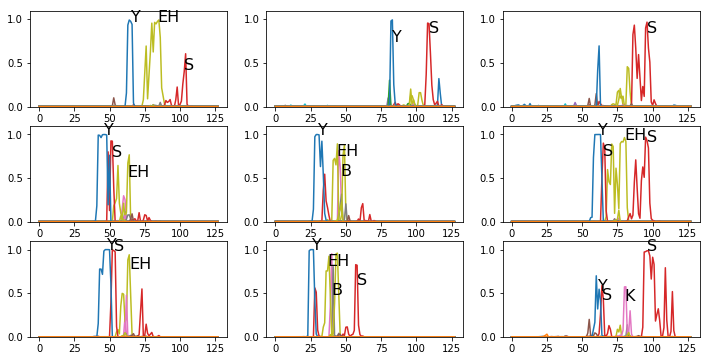

no -> ['N', 'OW']


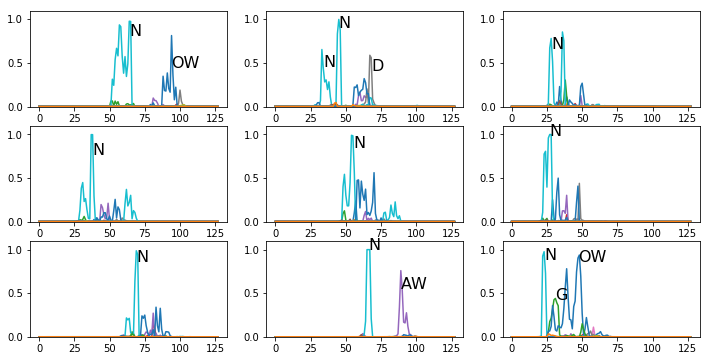

up -> ['AH', 'P']


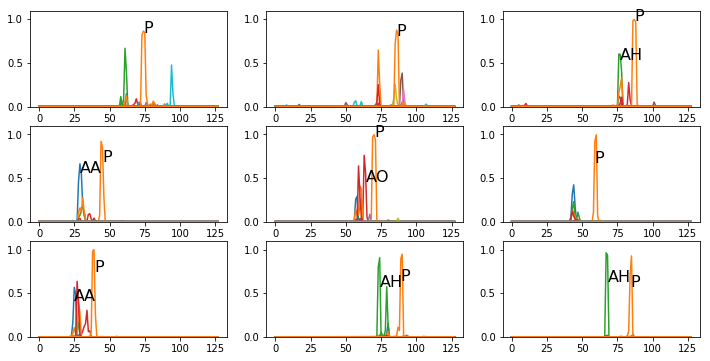

down -> ['D', 'AW', 'N']


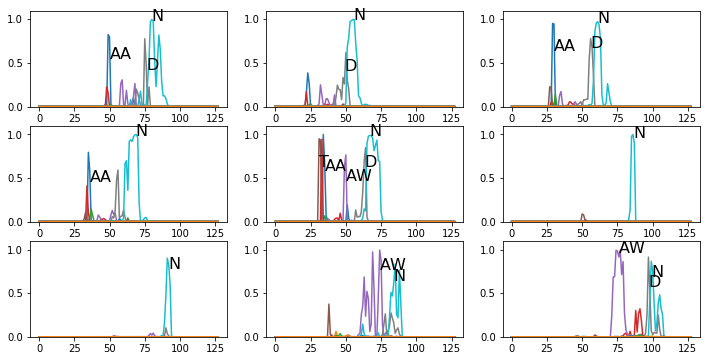

left -> ['L', 'EH', 'F', 'T']


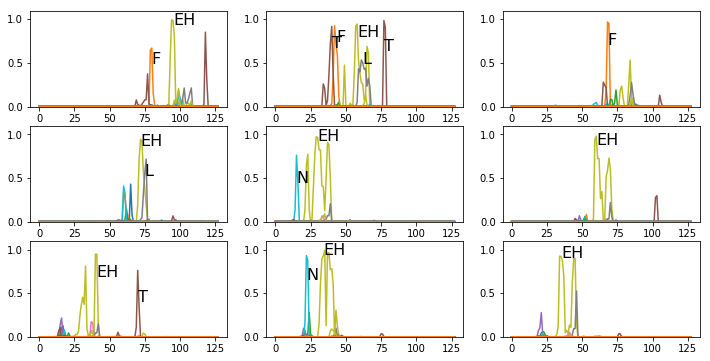

right -> ['R', 'AY', 'T']


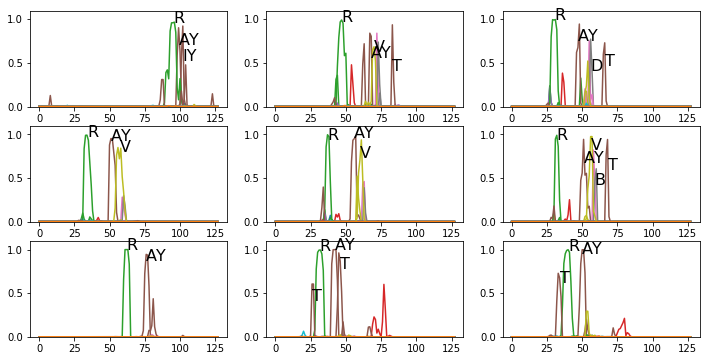

on -> ['AA', 'N']


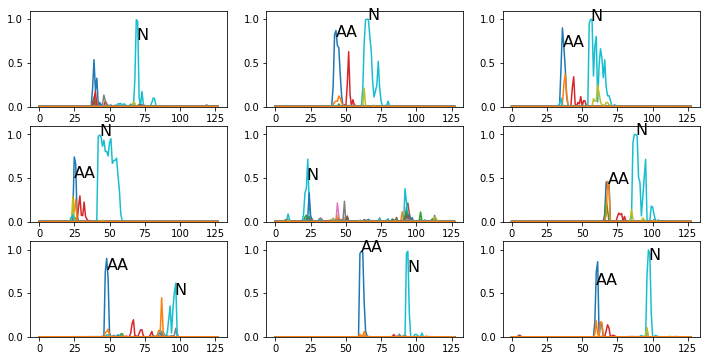

off -> ['AO', 'F']


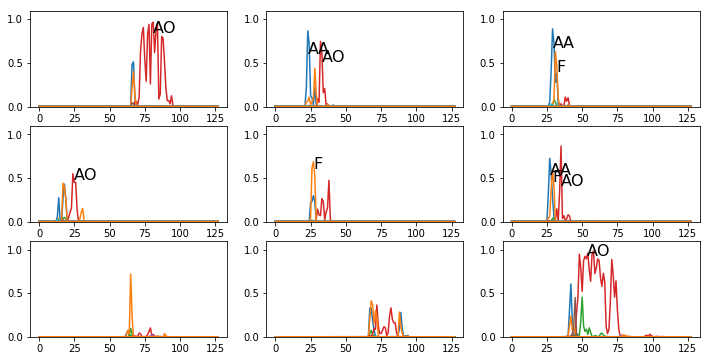

stop -> ['S', 'T', 'AA', 'P']


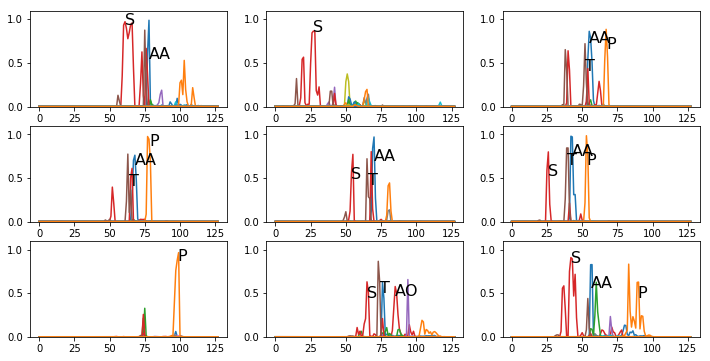

go -> ['G', 'OW']


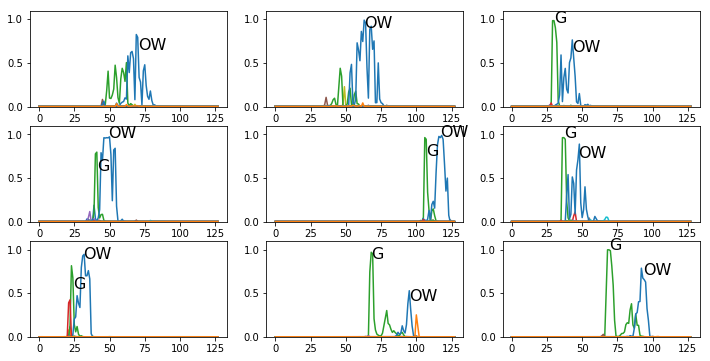

In [41]:
for word in ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]:
    print(word, "->", cmudict[word])
    b_files = dev_labels.index[dev_labels["word"].values == word][:9]
    b_labels = dev_labels.loc[b_files]
    example_batch = load_batch(b_files, **dev_loading_kwargs)
    
    phone_preds = phoneme_detector.predict(example_batch[0])
    fig, axes = plt.subplots(3, 3, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(len(axes)):
        axes[i].set_ylim(0, 1.1)
        annotated_phoneme_map(phone_preds[i, :, :-1], phoneme_labels=group_encoder.group_labels, ax=axes[i])
    plt.show()

# Numbers

The model also tends to do a pretty decent job on the numbers.

one -> ['W', 'AH', 'N']


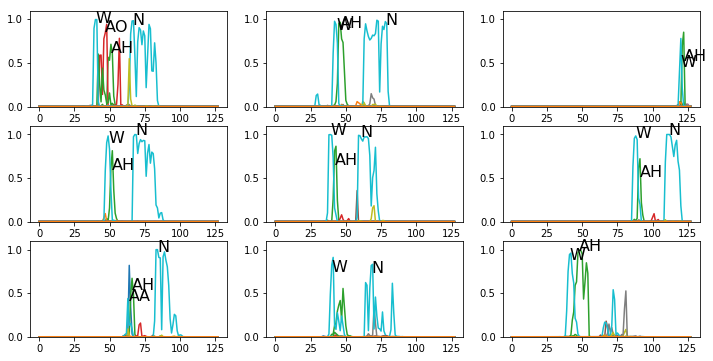

two -> ['T', 'UW']


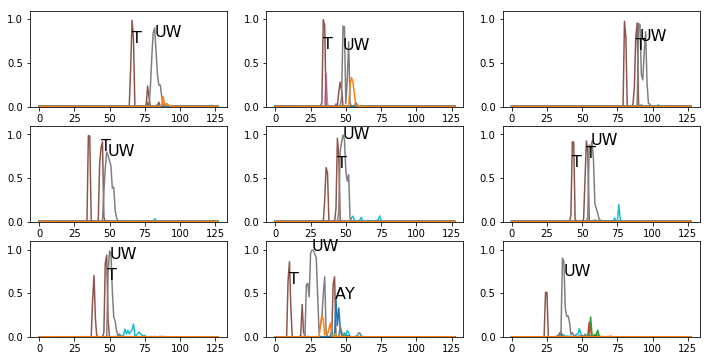

three -> ['TH', 'R', 'IY']


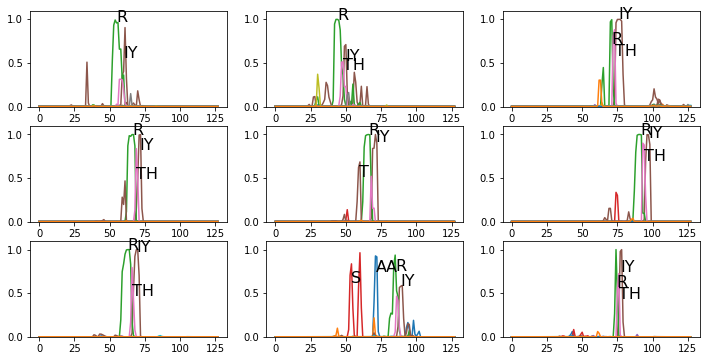

four -> ['F', 'AO', 'R']


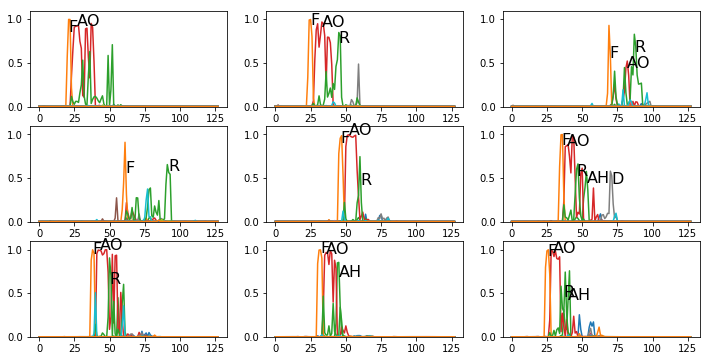

five -> ['F', 'AY', 'V']


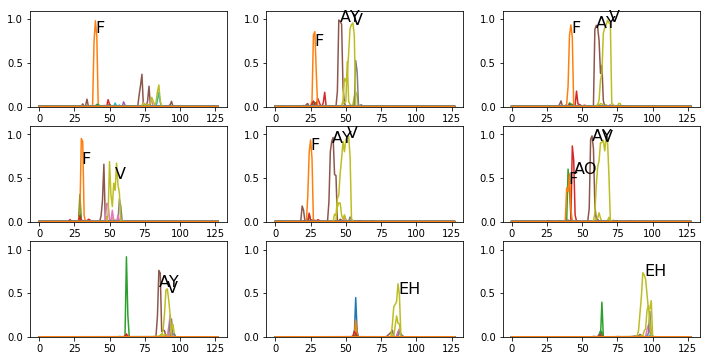

six -> ['S', 'IH', 'K', 'S']


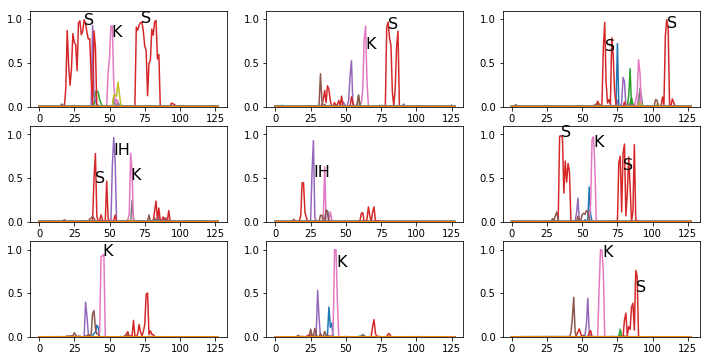

seven -> ['S', 'EH', 'V', 'AH', 'N']


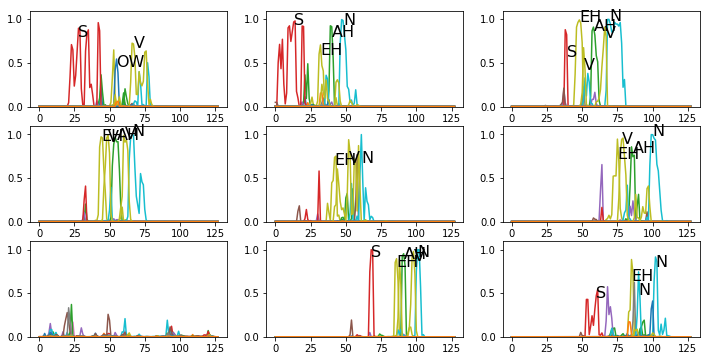

eight -> ['EY', 'T']


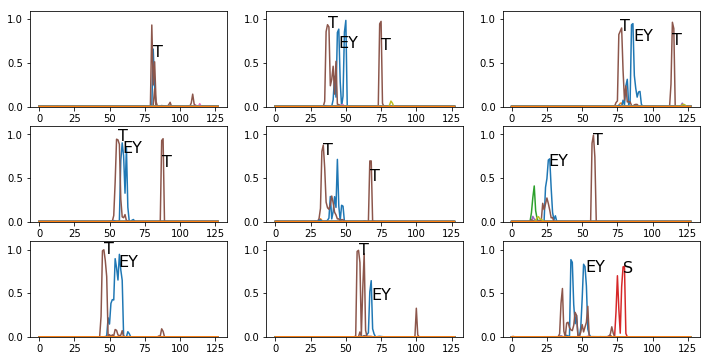

nine -> ['N', 'AY', 'N']


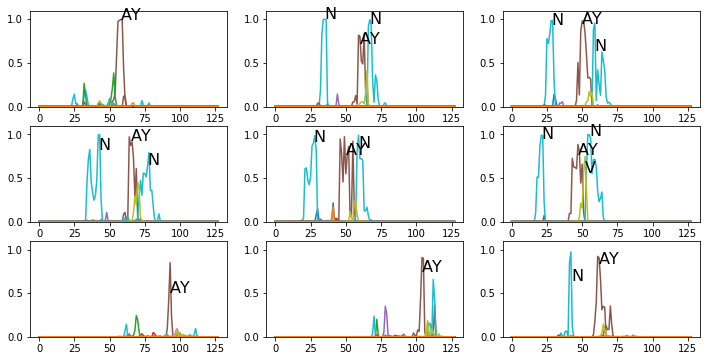

zero -> ['Z', 'IH', 'R', 'OW']


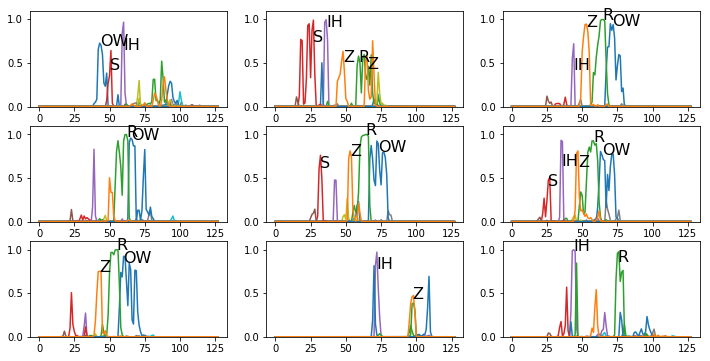

In [42]:
for word in ["one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "zero"]:
    print(word, "->", cmudict[word])
    b_files = dev_labels.index[dev_labels["word"].values == word][:9]
    b_labels = dev_labels.loc[b_files]
    example_batch = load_batch(b_files, **dev_loading_kwargs)
    
    phone_preds = phoneme_detector.predict(example_batch[0])
    fig, axes = plt.subplots(3, 3, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(len(axes)):
        axes[i].set_ylim(0, 1.1)
        annotated_phoneme_map(phone_preds[i, :, :-1], phoneme_labels=group_encoder.group_labels, ax=axes[i])
    plt.show()

### Misc Words



bed -> ['B', 'EH', 'D']


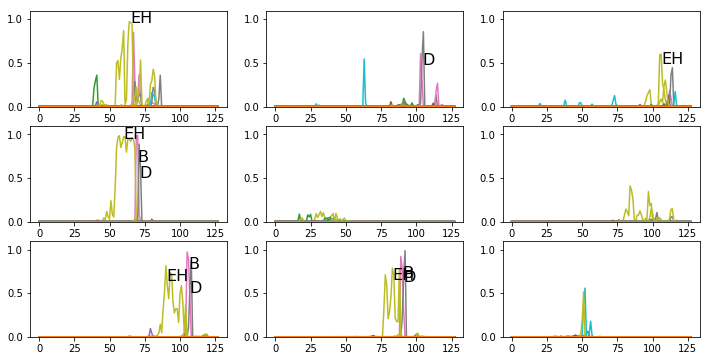

bird -> ['B', 'ER', 'D']


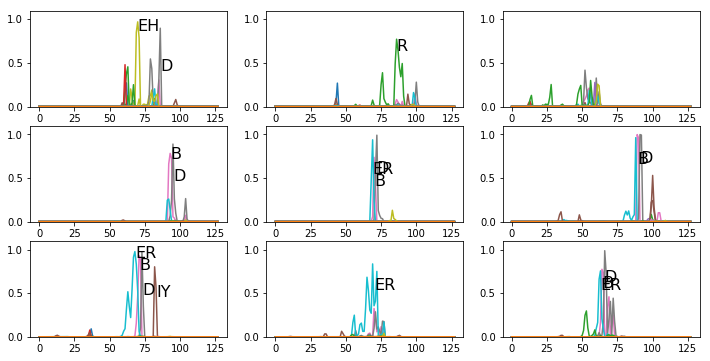

cat -> ['K', 'AE', 'T']


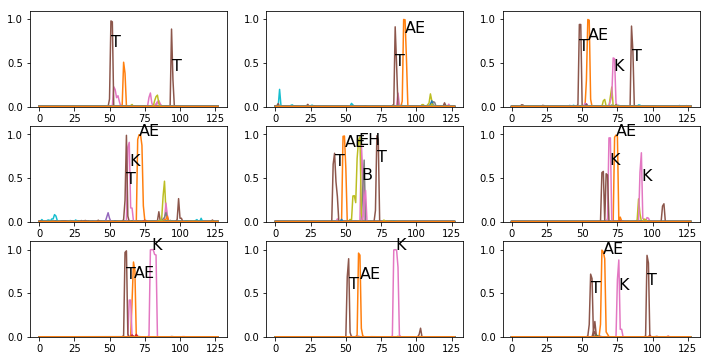

dog -> ['D', 'AO', 'G']


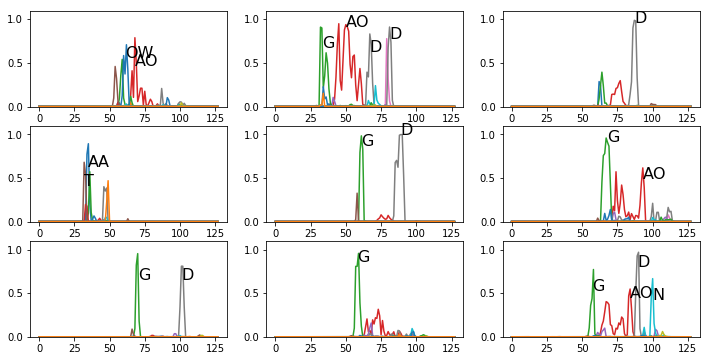

happy -> ['HH', 'AE', 'P', 'IY']


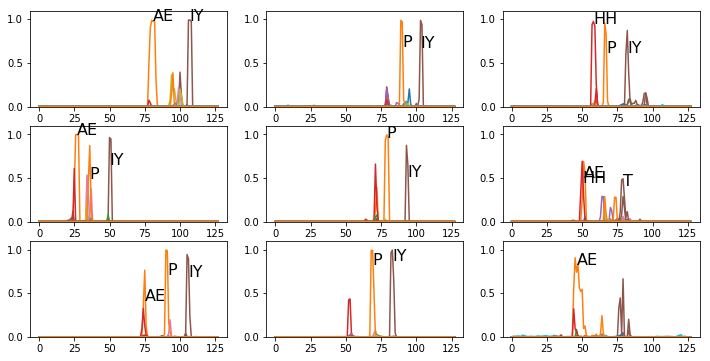

house -> ['HH', 'AW', 'S']


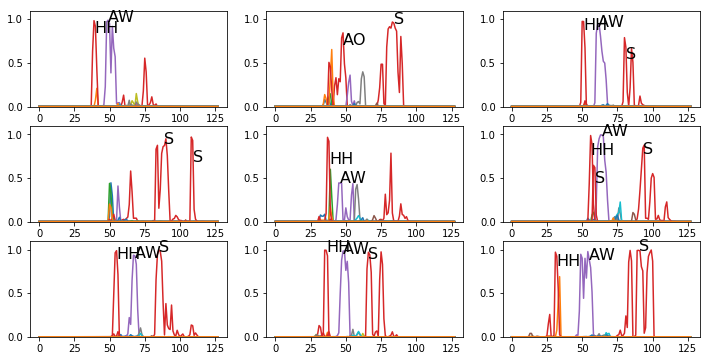

marvin -> ['M', 'AA', 'R', 'V', 'IH', 'N']


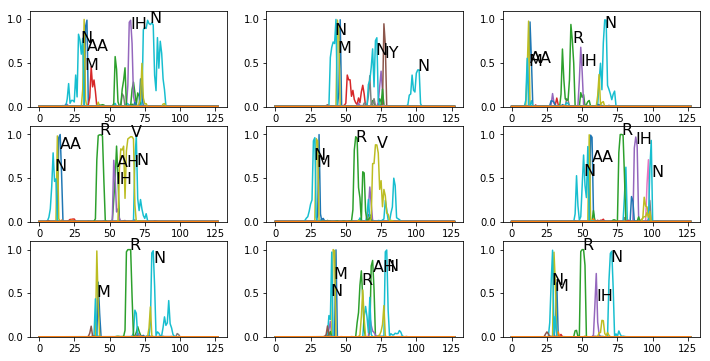

sheila -> ['SH', 'IY', 'L', 'AH']


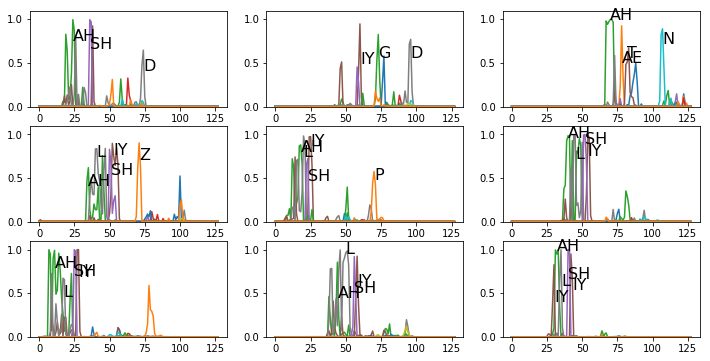

tree -> ['T', 'R', 'IY']


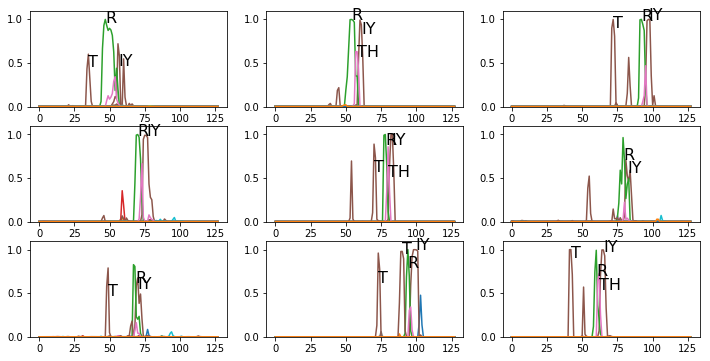

wow -> ['W', 'AW']


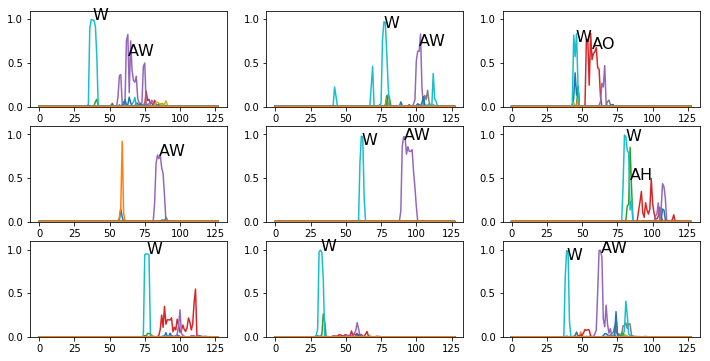

In [43]:
for word in ["bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"]:
    print(word, "->", cmudict[word])
    b_files = dev_labels.index[dev_labels["word"].values == word][:9]
    b_labels = dev_labels.loc[b_files]
    example_batch = load_batch(b_files, **dev_loading_kwargs)
    
    phone_preds = phoneme_detector.predict(example_batch[0])
    fig, axes = plt.subplots(3, 3, figsize=(12, 6))
    axes = axes.ravel()
    for i in range(len(axes)):
        axes[i].set_ylim(0, 1.1)
        annotated_phoneme_map(phone_preds[i, :, :-1], phoneme_labels=group_encoder.group_labels, ax=axes[i])
    plt.show()

# Final Thoughts

I think the degree of sucess in terms of identifying phonemes is really rather surprising given the fact that we neither fed any temporaly labeled data in to the model nor used a temporally aware metric like CTC and yet still the phonetic structure in time of some words comes through all right. I think this is a really good sign for the generalizability of these phoneme models for other applications.

Doubtless the phoneme probabilities could be improved by incorporating more contextual information for example by using an RNN instead of narrow receptive field CNN. But I think that a large part of the interest of this model is that because there is no network memory the phoneme maps are entirely local functions. That means we can feed arbitrary length audio streams in to the phoneme mapping model and get stable outputs without having to worry that the history of the audio feed might be influencing the results.

Probably we could get better results by applying a CTC loss and feeding in the actual desired sequence of sounds instead of simply treating each sound clip as a bag of sounds. CTC loss models can be unstable to train though and so it might still make sense to include the bag of phonemes metric with smaller weight just to get the model rolling.

Really though I don't think it is the metric whic is limiting the accuracy of the model but the data set. There are only 30 words total included in the data and those words correspond to 32 of the 44 ARPAbet phoenemes. Although most phonemes appear in multiple different words there are several that appear in only exactly one word. Here is the mapping from phoneme sound to word that is induced by the particular set of 30 words included in the training data.

In [49]:
mspec.group_encoder.label_to_group

{'AA': ['marvin', 'on', 'stop'],
 'AE': ['cat', 'happy'],
 'AH': ['one', 'seven', 'sheila', 'up'],
 'AO': ['dog', 'four', 'off'],
 'AW': ['down', 'house', 'wow'],
 'AY': ['five', 'nine', 'right'],
 'B': ['bed', 'bird'],
 'D': ['bed', 'bird', 'dog', 'down'],
 'EH': ['bed', 'left', 'seven', 'yes'],
 'ER': ['bird'],
 'EY': ['eight'],
 'F': ['five', 'four', 'left', 'off'],
 'G': ['dog', 'go'],
 'HH': ['happy', 'house'],
 'IH': ['marvin', 'six', 'zero'],
 'IY': ['happy', 'sheila', 'three', 'tree'],
 'K': ['cat', 'six'],
 'L': ['left', 'sheila'],
 'M': ['marvin'],
 'N': ['down', 'marvin', 'nine', 'no', 'on', 'one', 'seven'],
 'OW': ['go', 'no', 'zero'],
 'P': ['happy', 'stop', 'up'],
 'R': ['four', 'marvin', 'right', 'three', 'tree', 'zero'],
 'S': ['house', 'seven', 'six', 'stop', 'yes'],
 'SH': ['sheila'],
 'T': ['cat', 'eight', 'left', 'right', 'stop', 'tree', 'two'],
 'TH': ['three'],
 'UW': ['two'],
 'V': ['five', 'marvin', 'seven'],
 'W': ['one', 'wow'],
 'Y': ['yes'],
 'Z': ['zero']}

This data set looks to be close to the minimum sufficient to learn to distinguish all 32 of these sounds from the others. No two sounds always occur together. However there are a number of sounds which only appear in pairs with specific other sounds. For example this is true of all the sounds which appear in only one word (of which there are 9) and this is also true for B which only occurs in bed and bird. With a richer set of example words this model might improve even without incorporating anything fancy like CTC. 